#  Project group 30 
## Image colorization by combining semantic segmentation and autoencoding

## Imports

In [1]:
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor
from torch import nn, optim
from torchvision.transforms import Compose, RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from PIL import Image, ImageOps 

#!pip install kornia
from matplotlib.colors import LinearSegmentedColormap
import kornia

import glob
import os

## Paths

In [2]:
train_path = "\Train"

val_path = "\Validation"

test_path = "\Test"

## Dataloader

In [3]:
class DataLoaderSegmentationAndColorisation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentationAndColorisation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) # PIL images
            SEG = Image.open(mask_path)
        
            if self.transform is not None:
                data = self.transform(data)
                SEG = self.transform(SEG) # segmentation should probably only be resized

            # SOMETHING FISHY HERE
            #transform = transforms.Compose([ 
            #    transforms.PILToTensor() 
            #]) 

            #img_lab = kornia.color.rgb_to_lab(transform(data))
            SEG = np.array(SEG)
            np.moveaxis(SEG, 0, -1).shape
            SEG = torch.from_numpy(SEG).float()
        
            img_rgb = np.array(data)
            np.moveaxis(img_rgb, 0, -1).shape
            img_rgb = torch.from_numpy(img_rgb).float()
            img_rgb = img_rgb/255
            img_lab = kornia.color.rgb_to_lab(img_rgb.permute(2, 0, 1))

            L = (img_lab.permute(1, 2, 0))[:,:,0]
            A = (img_lab.permute(1, 2, 0))[:,:,1]
            B = (img_lab.permute(1, 2, 0))[:,:,2]
        
            input = torch.stack((L,SEG))
            output = torch.stack((A,B))
            
            # data = [L, SEG] label = [A, B]
            input = input.to(torch.float32) 
            output = output.to(torch.float32)       
            return input, output

    def __len__(self):
        return len(self.img_files)


class DataLoaderAutoEncoder(data.Dataset):
    def __init__(self, folder_path, transform):
        super().__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            img_rgb = Image.open(img_path)

            # Perform transforms, if any.
            if self.transform is not None:
                label = self.transform(img_rgb)
            
            label = np.array(label)
            np.moveaxis(label, 0, -1).shape
            label = torch.from_numpy(label).float()
            label = label/255
            label = kornia.color.rgb_to_lab(label.permute(2, 0, 1))
            data = label[0, :, :]
            label = label[1:, :, :]
     
            return data, label

    def __len__(self):
        return len(self.img_files)

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) # PIL images
            label = Image.open(mask_path) 
            
            # Perform transforms, if any.
            if self.transform is not None:
                data = self.transform(data)
                label = self.transform(label)

            data = np.array(data)
            np.moveaxis(data, 0, -1).shape
            data = torch.from_numpy(data).float()
            data = data/255
            data = kornia.color.rgb_to_lab(data.permute(2, 0, 1))
            data = data[0, :, :]

            
            label = np.array(label)
            np.moveaxis(label, 0, -1).shape
            
            return data, label

    def __len__(self):
        return len(self.img_files)

In [4]:
batch_size = 1
n_classes = 35 # Crashes if too low idk why 
img_size = 256

test_transforms = Compose([Resize((img_size,img_size), antialias=True)])

test_set_seg = DataLoaderSegmentation(test_path, test_transforms)
test_set_C = DataLoaderAutoEncoder(test_path, test_transforms)
test_set_CS = DataLoaderSegmentationAndColorisation(test_path, test_transforms)

test_dataloader_seg = DataLoader(test_set_seg, batch_size=batch_size, shuffle=True)
test_dataloader_C = DataLoader(test_set_C, batch_size=batch_size, shuffle=True)
test_dataloader_CS = DataLoader(test_set_CS, batch_size=batch_size, shuffle=True)


## Test images

torch.Size([256, 256])
torch.Size([2, 256, 256])


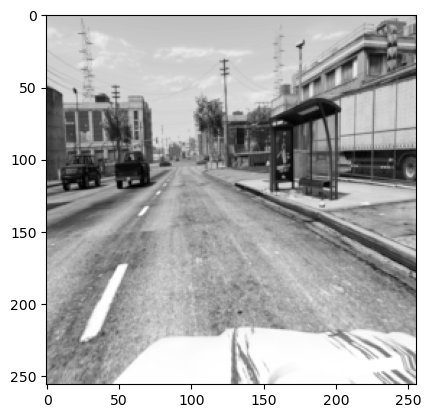

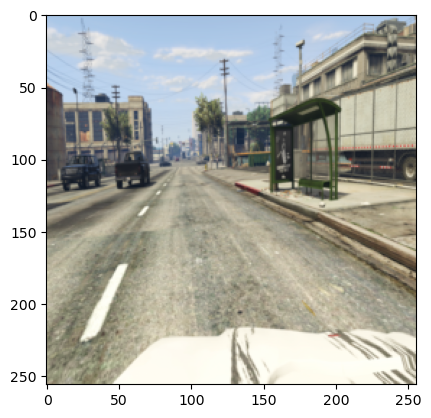

In [5]:
img, label = test_set_C[1]
print(img.shape)
print(label.shape)
plt.figure(0)
plt.imshow(img[:,:], 'grey')
plt.figure(1)
target_img = kornia.color.lab_to_rgb(torch.stack((img, label[0,:,:], label[1,:,:]),0)).permute(1, 2, 0)
plt.imshow(target_img)

## UNETs

In [6]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs) 
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
        
class build_unet_CS(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(2, 64) # Maybe 2 since L and SEG
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, 2, kernel_size=1, padding=0) # 2 since A and B
    def forward(self, inputs):
        """ Encoder """
        #print(inputs.shape)
        #inputs = inputs.permute(1,0,2,3)
        #inputs = torch.squeeze(inputs)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

class build_unet_C(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, 2, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        inputs = inputs.permute(1,0,2,3)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

class build_unet_seg(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, n_classes, kernel_size=1, padding=0) # 32 or 31 channels
    def forward(self, inputs):
        """ Encoder """
        inputs = inputs.permute(1,0,2,3)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

## Creat the model

In [9]:
# Read models from disk
print("Reading models from disk")
#pretrained = torch.load('segmentation_model.pth', map_location=lambda storage, loc: storage)
#Segmentaion_model = build_unet()
#Segmentaion_model.load_state_dict(torch.load('segmentation_model.pth'))

# Seg
Seg_model = build_unet_seg()
Seg_model.load_state_dict(torch.load('segmentation_model.pth'))

# C
C_model = build_unet_C()
C_model.load_state_dict(torch.load('autoencoder_model.pth'))

# CS
CS_true_model = build_unet_CS()
CS_true_model.load_state_dict(torch.load('segmentation_and_color_model.pth'))

CS_model = build_unet_CS()
CS_model.load_state_dict(torch.load('segmentation_and_color_model_full.pth'))

Reading models from disk


<All keys matched successfully>

## Run the models on one image

## drop down

C:\Users\soder\AppData\Local\Temp\ipykernel_12452\977059972.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


(-0.5, 255.5, 255.5, -0.5)

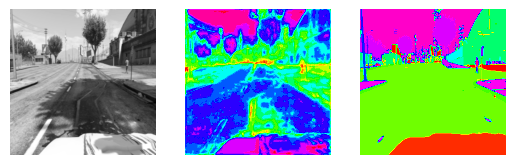

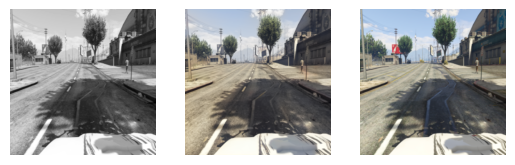

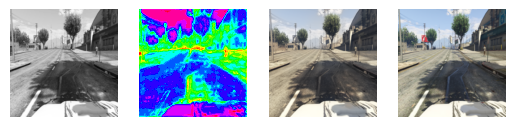

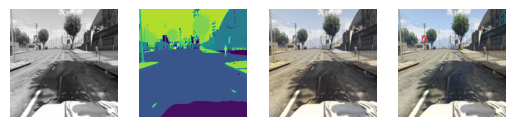

In [10]:
# interesting indices
#
#
#
#
idx = 15
n_classes = 35

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_classes)

imgSeg, labelSeg = test_set_seg[idx]
imgC, labelC = test_set_C[idx] # [L], [A,B]
imgCS, labelCS = test_set_CS[idx] # [L,SEG], [A,B]

input_seg = imgSeg
input_seg = input_seg[None, None, :]

input_C = imgC
input_C = input_C[None, None, :]

zSeg = Seg_model.forward(input_seg)
zSeg = torch.round(zSeg)
zSeg, _ = torch.max(zSeg[0,:,:,:],dim=0)
input_CS = torch.stack((imgCS[0,:,:], zSeg))
input_CS = input_CS[None, :]

input_CStrue = imgCS
input_CStrue = input_CStrue[None, :]

zC = C_model.forward(input_C)
zCS = CS_model.forward(input_CS)
zCStrue = CS_true_model.forward(input_CStrue)

# DO SOME PLOTTING SEG
zSeg = zSeg.detach().numpy()
f, axarr = plt.subplots(1,3)
axarr[0].imshow(input_seg[0,0,:,:],'grey')
axarr[1].imshow(zSeg[:,:],cmap)
axarr[2].imshow(labelSeg[:,:],cmap)   
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

# DO SOME PLOTTING C
A_output = zC[0,0,:,:]
B_output = zC[0,1,:,:]

inputs = torch.squeeze(input_C)
                
L_true = inputs # [256, 256] [img, img]
A_true = labelC[0,:,:] # [256, 256] [img, img]
B_true = labelC[1,:,:] # [256, 256] [img, img]

output_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)

output_img = output_img.detach().numpy()

f, axarr = plt.subplots(1,3)
axarr[0].imshow(L_true,'grey')         # L input
axarr[1].imshow(output_img) # Output picture (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
axarr[2].imshow(target_img) # Facit picture
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

# DO SOME PLOTTING CS
A_output = zCS[0,0,:,:]
B_output = zCS[0,1,:,:]

inputs = torch.squeeze(input_CS)

L_true = inputs[0,:,:] # [256, 256] [img, img]
A_true = labelCS[0,:,:] # [256, 256] [img, img]
B_true = labelCS[1,:,:] # [256, 256] [img, img]

output_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)

L_true = L_true.detach().numpy()
inputs = inputs[1,:,:].detach().numpy()
output_img = output_img.detach().numpy()
target_img = target_img.detach().numpy()

f, axarr = plt.subplots(1,4)

axarr[0].imshow(L_true,'grey') 
axarr[1].imshow(inputs, cmap)     # SEG input
axarr[2].imshow(output_img) # Output picture (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
axarr[3].imshow(target_img) # Facit picture
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')

# DO SOME PLOTTING CStrue
A_output = zCStrue[0,0,:,:]
B_output = zCStrue[0,1,:,:]

inputs = torch.squeeze(input_CStrue)
                
L_true = input_CStrue[0,0,:,:] # [256, 256] [img, img]
A_true = labelCS[0,:,:] # [256, 256] [img, img]
B_true = labelCS[1,:,:] # [256, 256] [img, img]

output_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)

output_img = output_img.detach().numpy()

f, axarr = plt.subplots(1,4)
axarr[0].imshow(L_true,'grey')         # L input
axarr[1].imshow(inputs[1,:,:])     # SEG input
axarr[2].imshow(output_img) # Output picture (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
axarr[3].imshow(target_img) # Facit picture
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')


## Image 1
L, SEG, COLOR

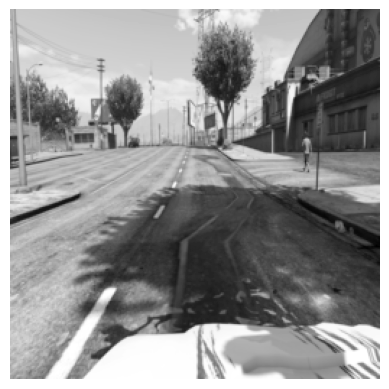

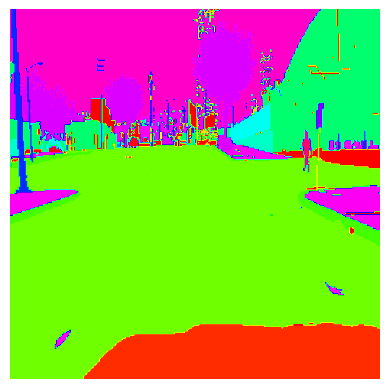

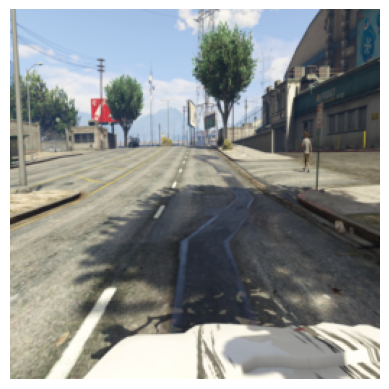

In [11]:
# Lightness
plt.figure
plt.imshow(L_true,'grey')  
plt.axis('off')
plt.show()

# Segmentation
plt.figure
inp = input_CStrue[0,1,:,:].detach().numpy()
plt.imshow(inp, cmap)   
plt.axis('off')
plt.show()

# Colorised
plt.figure
plt.imshow(target_img) 
plt.axis('off')
plt.show()

## Image 2 engagement 2
LAB, L, C, CS

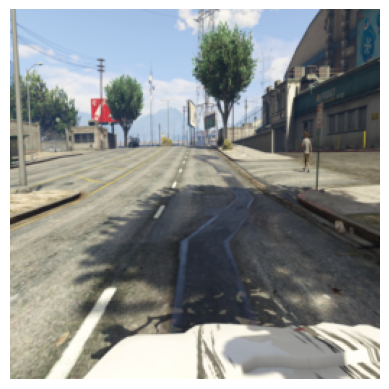

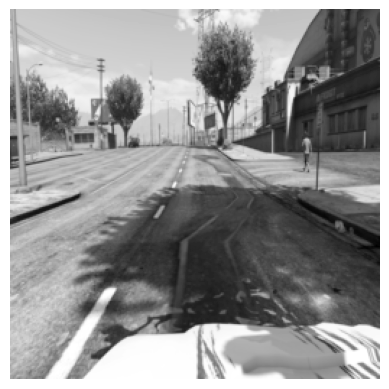

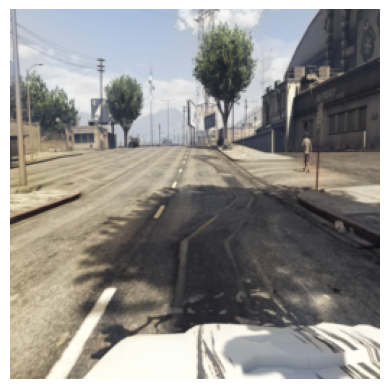

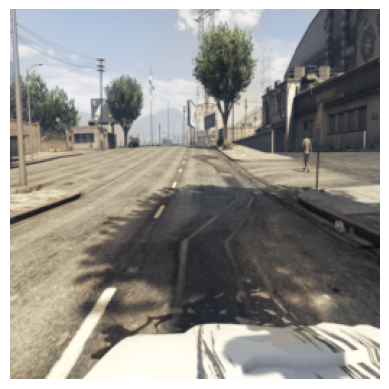

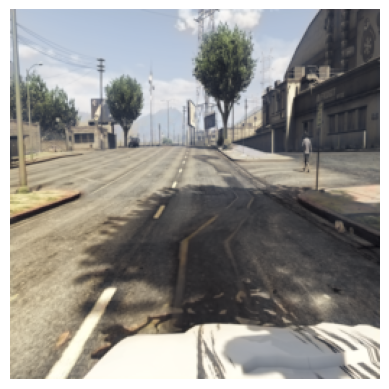

In [12]:
# Colorised
plt.figure
plt.imshow(target_img) 
plt.axis('off')
plt.show()

# Lightness
plt.figure
plt.imshow(L_true,'grey')  
plt.axis('off')
plt.show()

# C
A_output = zC[0,0,:,:]
B_output = zC[0,1,:,:]
output_C = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
output_C = output_C.detach().numpy()
plt.figure
plt.imshow(output_C)
plt.axis('off')
plt.show()

# CS
A_output = zCS[0,0,:,:]
B_output = zCS[0,1,:,:]


                
L_true = input_CS[0,0,:,:] # [256, 256] [img, img]
A_true = labelCS[0,:,:] # [256, 256] [img, img]
B_true = labelCS[1,:,:] # [256, 256] [img, img]

output_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)

output_img = output_img.detach().numpy()

plt.figure
plt.imshow(output_img)
plt.axis('off')
plt.show()

# CStrue
A_output = zCStrue[0,0,:,:]
B_output = zCStrue[0,1,:,:]


                
L_true = input_CS[0,0,:,:] # [256, 256] [img, img]
A_true = labelCS[0,:,:] # [256, 256] [img, img]
B_true = labelCS[1,:,:] # [256, 256] [img, img]

output_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_output, B_output),0)).permute(1, 2, 0)
target_img = kornia.color.lab_to_rgb(torch.stack((L_true, A_true, B_true),0)).permute(1, 2, 0)

output_img = output_img.detach().numpy()

plt.figure
plt.imshow(output_img)
plt.axis('off')
plt.show()


## Loop through all test

In [18]:
test_size = len(test_set_CS) # 250
C_losses, CS_losses, CStrue_losses = [], [], []
loss_fn = nn.MSELoss()
test_loss_C_cum = 0
test_loss_CS_cum = 0
test_loss_CStrue_cum = 0
print_every = 50

for i in range(0,test_size):
    # Compute loss for each image in the test set for every model
    imgC, labelC = test_set_C[i]
    imgCS, labelCS = test_set_CS[i]
    
    input_C = imgC
    input_C = input_C[None,None, :]

    input_seg = imgC
    input_seg = input_seg[None,None, :]
    zSeg = Seg_model.forward(input_seg)
    zSeg = torch.round(zSeg)
    zSeg, _ = torch.max(zSeg[0,:,:,:],dim=0)
    input_CS = torch.stack((imgCS[0,:,:], zSeg))
    input_CS = input_CS[None, :]
    
    input_CStrue = imgCS
    input_CStrue = input_CStrue[None, :]
    
    zC = C_model.forward(input_C)
    zCS = CS_model.forward(input_CS)
    zCStrue = CS_true_model.forward(input_CStrue)
    
    loss_C = loss_fn(zC, label.long()) 
    loss_CS = loss_fn(zCS, label.long()) 
    loss_CStrue = loss_fn(zCStrue, label.long()) 

    if print_every is not None and i % print_every == 0:
        print(f'Test: {i}/{test_size:}')
        print('Loss for C:')
        print(loss_C.detach().numpy())
        print('Loss for CS:')
        print(loss_CS.detach().numpy())
        print('Loss for CStrue:')
        print(loss_CStrue.detach().numpy())
        print(' ')
    
    test_loss_C_cum += loss_C.item()
    test_loss_CS_cum += loss_CS.item()
    test_loss_CStrue_cum += loss_CStrue.item()

print('Average loss for test C:')
print(test_loss_C_cum/test_size)
print('Average loss for test CS:')
print(test_loss_CS_cum/test_size)
print('Average loss for test CStrue:')
print(test_loss_CStrue_cum/test_size)

Test: 0/250
Loss for C:
41.693054
Loss for CS:
40.49493
Loss for CStrue:
40.68864
 
Test: 50/250
Loss for C:
42.766453
Loss for CS:
39.63454
Loss for CStrue:
39.66802
 
Test: 100/250
Loss for C:
38.225933
Loss for CS:
42.28178
Loss for CStrue:
39.973774
 
Test: 150/250
Loss for C:
60.343945
Loss for CS:
55.115326
Loss for CStrue:
56.77275
 
Test: 200/250
Loss for C:
65.060646
Loss for CS:
66.30965
Loss for CStrue:
58.022644
 
Average loss for test C:
46.06330065917969
Average loss for test CS:
44.85069253540039
Average loss for test CStrue:
44.453722793579104
